In [57]:
version = "REPLACE_PACKAGE_VERSION"

---
# Assignment 4 Part 2: Counting in a Data Stream (50 pts)

In this assignment, we're going to implement two algorithms for counting items in a data stream. 

In [58]:
import json
from emoji import UNICODE_EMOJI

def extract_emojis(text):
    """
    Extract all emojis from a str
    """
    return [ch for ch in text if ch in UNICODE_EMOJI]

class TwitterStream:
    """
    Used to simulate a Twitter stream. 
    """
    
    def __init__(self, data_file):
        self.data_file = data_file
        self.data = open(self.data_file, "r")
    
    def __iter__(self):
        return self.reset()
    
    def __next__(self):
        next_line = self.data.readline()
        if next_line:
            return json.loads(next_line)["text"]
        else:
            raise StopIteration
    
    def __del__(self):
        if not self.data.closed:
            self.data.close()
    
    def reset(self):
        if not self.data.closed:
            self.data.close()
        self.data = open(self.data_file, "r")
        return self

Above we have imported the same `TwitterStream` class defined in Part 1 to simulate a Twitter stream. Remember, we are still facing one of the biggest challenges in mining data streams, that **we have limited storage capacity for the very high volume of incoming data, which may arrive at a very high velocity as well**. However, if we are only interested in the distribution of some simple items, such as emojis in this case, it might be possible to obtain approximate counts directly without curating a sample like what we did in Part 1. So let's now start exploring that possibility. 


Again, there's a helper function `extract_emojis` available that helps you extract all emojis from a piece of text, and the variable `UNICODE_EMOJI` is a collection of all emojis that are circulating around the world. 

## Question 1: Bloom Filters (25 pts)

Recall from the lectures that a Bloom filter doesn't really count items in a data stream but is able to tell
* that an item has *definitely not appeared* in the data stream so far; or


* that an item has *possibly appeared* in the data stream so far. 

In this question, we'll implement a Bloom filter for emojis in a Twitter stream. 

A partially completed `BloomFilter` class is given to you below. It already has the two key ingradients of a Bloom filter: a number of `slots` to record the appearance of an item and a collection, `hash_fns`, of hash functions to compute the fingerprint of an item. Your job is to complete the following two functions:

* `check_appearance`: it receives a single item and returns a `bool` value indicating whether the item has appeared or not so far;


* `do_filtering`: it receives a stream object and iterates over the stream. During each iteration, it extracts all emojis from a tweet, computes the fingerprint of each emoji and records the appearance of each emoji accordingly, as specified in the lecture slides. Finally, it returns a copy of the `slots` of your `BloomFilter` for grading at every iteration, which you don't need to worry about. **However, please do make sure that you don't inadvertently change the indentation of the `yield` statement.**

There is also an accompanying `HashFunction` class that provides simple and deterministic hash functions. Once instantiated, they behave just like ordinary Python functions. For example, the code below computes the fingerprint of 😂, assuming we have `7919` (the 1000-th prime number) slots.

In [59]:
class HashFunction:
    def __init__(self, num_slots):
        self.num_slots = num_slots
        
    def __call__(self, x):
        return (hash(self) + hash(x)) % self.num_slots

h1, h2 = HashFunction(7919), HashFunction(7919)

# The two hash functions are distinct, but both are deterministic
print(h1("😂"), h2("😂"))
print(h1("😂"), h2("😂"))

del h1, h2

5359 5347
5359 5347


It's worth noting that two different instantiations of the `HashFunction` class lead to two distinct hash functions, in that they assign different fingerprints to the same emoji. However, they are both deterministic, in that they always assign the same fingerprint to an emoji regardless of how many times you apply them. Every time you re-run the code above, the two hash functions will change and so will the fingerprints, but they will always be deterministic. These two properties may have some implications on your debugging strategies later on. 

In [126]:
import numpy as np

def extract_emojis(text):
    """
    Extract all emojis from a str
    """
    return [ch for ch in text if ch in UNICODE_EMOJI['en']]


class BloomFilter:
    
    def __init__(self, num_slots, num_hash_fns):
        
        self.slots = np.zeros(num_slots, dtype=int)
        self.hash_fns = [HashFunction(num_slots) for _ in range(num_hash_fns)] # A list of distinct hash functions

    def check_appearance(self, item):
        """
        Returns a bool value indicating whether an item has appeared or not
        """
        
        has_appeared = None
        
        for hash_fn in self.hash_fns:
            appeared = hash_fn(item)
            if not self.slots[appeared]:
                has_appeared = False
            else:
                has_appeared = True
        
        # raise NotImplementedError()
        
        return has_appeared
    
    def do_filtering(self, stream):
        """
        Iterates over a stream, collects items of interest, calculates the fingerprints and records the appearance
        """
    
        self.slots = np.zeros_like(self.slots) # reset the slots
        
        for item in stream: # iterate over the stream
            
            for e in extract_emojis(item):
  
                for hash_fn in self.hash_fns:
                    appeared = hash_fn(e)
                    self.slots[appeared] = True

            # raise NotImplementedError()
            
            # returns a copy of slots at the end of every iteration for grading - code given
            yield self.slots.copy()

In [127]:
# Autograder tests

from emoji import UNICODE_EMOJI

twitter_stream = TwitterStream("assets/tweets")

num_slots, num_hash_fns = 7919, 5
stu_ans = BloomFilter(num_slots, num_hash_fns)

# Collect emojis that appeared and that didn't appear
emojis_appeared = set()
for tweet in twitter_stream:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))
emojis_not_appeared = set(UNICODE_EMOJI.keys()) - emojis_appeared

# Do filtering. Don't have to collect the results. Just exhaust the stream
for _ in stu_ans.do_filtering(twitter_stream):
    pass


# Check that the check_appearance function returns a bool
assert isinstance(stu_ans.check_appearance("😂"), (bool, np.bool_)), "Q1: Your check_appearance function should return a bool value. "


# Check that every item that appeared should be marked as appeared - correctness
for emoji in emojis_appeared:
    assert stu_ans.check_appearance(emoji), f"Q1: {emoji} appeared but is marked as not appeared. "

    
# Check that every item that is marked as not appeared really didn't appear - no false negatives
for emoji in UNICODE_EMOJI:
    if not stu_ans.check_appearance(emoji):
        assert emoji in emojis_not_appeared, f"Q1: {emoji} marked as not appeared but actually appeared. "


# Start a new filtering for the hidden tests
stu_slots = stu_ans.do_filtering(twitter_stream)

# Some hidden tests


del num_slots, num_hash_fns, twitter_stream, stu_ans, stu_slots, emojis_appeared, emojis_not_appeared

## Question 2: Lossy Counter (25 pts)

With reference to the lecture slides, let's now implement a lossy counter for emojis. The lossy counter should maintain counts of all emojis seen so far and only update the counts once a "bucket" of tweets arrive. The "update" of counts should include increments due to the emojis contained in the new bucket and decrements because we want to gradually get rid of less recent emojis. 

Again, a partially completed `LossyCounter` class is given to you below. Your job is to complete the `do_counting` function. It receives a stream object and iterates over the stream. Once a bucket of tweets have fully arrived, it updates the emoji counts as specified in the lecture slides. It returns a copy of the `counts` of your `LossyCounter` for grading at every iteration, which you don't need to worry about. **However, please do make sure that you don't inadvertently change the indentation of the `yield` statement and that there is always a `yield` statement being executed *at every iteration*.**

A few notes on implementation:

* The autograder expects that all the requisite updates to emoji counts, **including both increments and decrements**, have been performed when it starts to check your `self.counts` for grading, **immediately after a full bucket of tweets have arrived**. For example, if `self.bucket_size == 5`, the autograder will examine the content of your `self.counts` for grading right after the fifth tweet has been consumed by your `LossyCounter`; 


* When your `LossyCounter` is dropping an emoji, it's not enough to set the count of that emoji to zero. The emoji must be completely deleted from your counts, as if it never appeared (why?);  


* You have complete freedom in how you'd like to implement the "bucket". In fact, not being a sampling algorithm, your `LossyCounter` doesn't have to actually store tweets in a bucket. You only need to make sure the emoji counts are updated correctly when a full bucket of tweets have arrived, since that's all what the autograder checks. 


* In the extreme case where the bucket size is strictly greater than the total number of tweets in the stream, your `LossyCounter` should not be lossy anymore, that is, we won't do decrements but only increments, since we would never see a full bucket arriving. 


In [146]:
from collections import defaultdict

def extract_emojis(text):
    """
    Extract all emojis from a str
    """
    return [ch for ch in text if ch in UNICODE_EMOJI['en']]

class LossyCounter:
    
    def __init__(self, bucket_size):
        
        self.bucket_size = bucket_size
        self.counts = defaultdict(int) # recommended to use defaultdict, but an ordinary dict works fine too
    
    def do_counting(self, stream):
        """
        Iterates over a stream, counts the items and drops the infrequent ones in a bucket
        """

        self.counts.clear() # reset the counts
        num_items_in_bucket = 0 # optional: the current number of items in the "bucket"
        
        for item in stream: # iterate over the stream
            
            # increment `num_items_in_bucket` every time you extract new emoji,
            num_items_in_bucket += 1
            
            for e in extract_emojis(item):
                
                self.counts[e] += 1
            # check if the bucket is full
            if num_items_in_bucket == self.bucket_size:

                deleted=[]
                # iterate over each emoji in the bucket
                for key, value in self.counts.items():
                    # decrement the count for the current emoji
                    self.counts[key] -= 1
                    # if the count for the current emoji is 0, remove it from the bucket
                    if self.counts[key] == 0:
                        deleted.append(key)

                for i in deleted:
                    del self.counts[i]

                num_items_in_bucket= 0

#             # raise NotImplementedError()
            
#             # returns a copy of counts at the end of every iteration for grading - code given
            yield self.counts.copy()

In [147]:
# Autograder tests

from collections import defaultdict

twitter_stream = TwitterStream("assets/tweets")

# Sanity checks for a trivial case - use a large bucket size to include all tweets
bucket_size = 100000
stu_ans = LossyCounter(bucket_size)

# Collect all emojis that appeared
emojis_appeared = set()
for tweet in twitter_stream:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))

# Do counting. Don't have to collect the results. Just exhaust the stream
for _ in stu_ans.do_counting(twitter_stream):
    pass


assert isinstance(stu_ans.counts, dict), "Q2: You should store counts in a dict. "

assert len(stu_ans.counts) == len(emojis_appeared), f"Q2: The length of your emoji counts ({len(stu_ans.counts)}) differs from the correct answer ({len(emojis_appeared)}). "

assert not (emojis_appeared - set(stu_ans.counts.keys())), f"Q2: Your emoji counts don't include {emojis_appeared - set(stu_ans.counts.keys())}. "

assert not (set(stu_ans.counts.keys()) - emojis_appeared), f"Q2: Your emoji counts contain extra emojis: {set(stu_ans.counts.keys()) - emojis_appeared}. "


# Re-define variables for the hidden tests
bucket_size = 100
stu_ans = LossyCounter(bucket_size)
stu_counts = stu_ans.do_counting(twitter_stream)

# Some hidden tests


del twitter_stream, stu_ans, stu_counts, emojis_appeared, bucket_size

Let's see what the emoji distribution is after all tweets are processed.

In [148]:
bucket_size = 100
stu_ans = LossyCounter(bucket_size)

# Do counting. Don't have to collect the results. Just exhaust the stream
for _ in stu_ans.do_counting(TwitterStream("assets/tweets")):
    pass

sorted_counts = {emoji: stu_ans.counts[emoji] for emoji in sorted(stu_ans.counts.keys(), key=stu_ans.counts.get, reverse=True)}
print(sorted_counts)

{'😂': 1304, '😭': 911, '❤': 592, '🤣': 401, '🥺': 318, '✨': 317, '🥰': 236, '🔥': 231, '🏻': 228, '🙏': 207, '😍': 205, '💙': 175, '👏': 106, '♥': 97, '♀': 94, '😊': 77, '👍': 72, '💕': 69, '☺': 53, '‼': 47, '🤔': 44, '♂': 25, '💜': 22, '🏼': 21, '😅': 18, '👇': 16, '💦': 13, '😔': 13, '💔': 12, '🤒': 11, '🙇': 11, '💎': 11, '⭐': 10, '😢': 10, '🤦': 9, '👑': 9, '🌸': 7, '😆': 7, '🏾': 7, '🏷': 7, '🏽': 6, '😘': 6, '🤷': 6, '💀': 5, '🙄': 5, '❗': 5, '💢': 5, '💚': 4, '😋': 4, '😹': 4, '🤐': 4, '👥': 4, '💥': 4, '💛': 3, '🐥': 3, '😡': 2, '🎁': 2, '💪': 2, '😠': 2, '🤤': 2, '🚨': 2, '🤪': 2, '📣': 2, '😀': 2, '🍆': 2, '😏': 2, '🤮': 1, '😩': 1, '🤭': 1, '🔘': 1, '🖤': 1, '😃': 1, '👀': 1, '▶': 1, '😷': 1, '😁': 1, '〰': 1}


Visualised in a bar graph, the emoji distribution seems to resemble a [Power Law](https://en.wikipedia.org/wiki/Power_law) distribution. A few emojis are used a lot while the majority of the emojis are rarely used. 

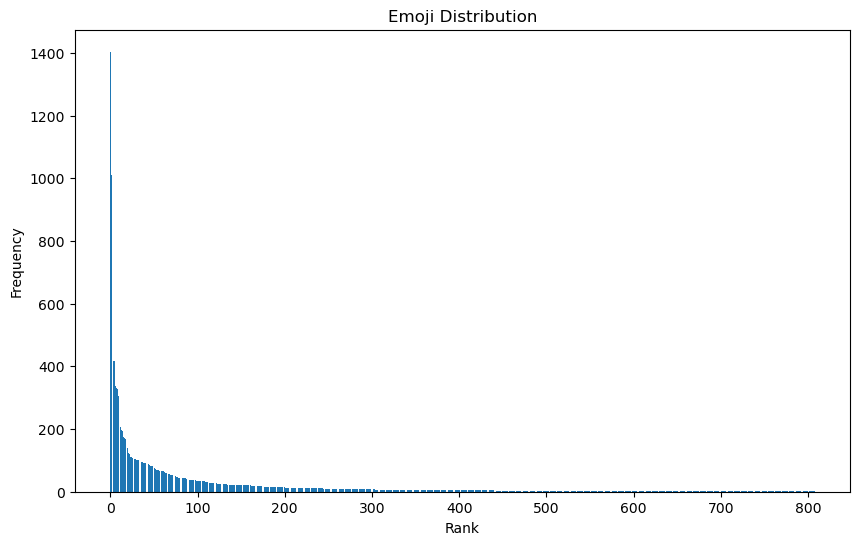

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax